# 0. Background

### Goal
Forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. <br>

#### Instructions
Specifically, build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.<br>

**Submission**
For each id in the test set, you must predict a value for the sales variable. The file should contain a header and have the following format:<br>
id,sales<br>
3000888,0.0<br>
3000889,0.0<br>
3000890,0.0<br>
3000891,0.0<br>
3000892,0.0<br>
etc.


### Provided...
-> Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices. <br>
-> Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this. <br>
-> A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake. <br>
-> Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. <br>
-> Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge. <br>
-> Additional holidays are days added to a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday). <br>

**-> Evaluation metric: RMSLE**<br>
The RMSLE is calculated as:<br>
$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(1+y^i)−log(1+y_{i}))^2}$<br>
where:<br>

$n$
 is the total number of instances,<br>
$y^i$
 is the predicted value of the target for instance (i),<br>
$yi$
 is the actual value of the target for instance (i), and,<br>
$log$
 is the natural logarithm.<br>

### Additional...
-> Train dataset period: 2013-01-01 to 2017-08-15 <br>
-> Test dataset period: 2017-08-16 to 2017-08-31 <br>
-> Christmas day is missing from the train dataset for a few years. The stores are likely closed on Christmas. <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load data

In [2]:
# Load data
df_train = pd.read_csv('train.csv', parse_dates=["date"])
df_trans = pd.read_csv('transactions.csv', parse_dates=["date"])
df_stores = pd.read_csv('stores.csv')
df_oil = pd.read_csv('oil.csv', parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
df_holi = pd.read_csv('holidays_events.csv', parse_dates=["date"])
df_sub = pd.read_csv('sample_submission.csv')
df_test = pd.read_csv('test.csv', parse_dates=["date"])

# 2. Explore data 

## df_train

### Key takeaways
1. Top 5 product families: Grocery I, Beverages, Produce, Cleaning, Dairy.
2. Promotions and sales have a positive linear relationships.
3. Promotions are most common on Wednesdays, Fridays, and holidays
4. Promotions (total sum) started mid 2015 and have steadily increased since then.

In [3]:
# Store count = 54
df_train.store_nbr.nunique()

# Same stores in training and test sets
df_train.store_nbr.unique() == df_test.store_nbr.unique()

# Family of products count = 33
df_train.family.nunique()

# Same family of products in training and test sets
df_train.family.unique() == df_test.family.unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [4]:
# Total sales by store
dfStoreSales = df_train.groupby(["store_nbr"]).sales.sum().reset_index().sort_values(by = 'sales', ascending=False)
dfStoreSales.describe()

,store_nbr,sales
count,54.000000,5.400000e+01
mean,27.500000,1.988231e+07
std,15.732133,1.329537e+07
min,1.000000,2.696170e+06
25%,14.250000,1.109715e+07
50%,27.500000,1.599205e+07
75%,40.750000,2.482969e+07
max,54.000000,6.208755e+07


In [5]:
# Is every product family reported for every date and store_nbr?
# Store numbers - Every one (54 total) reported for every date in training set
df_store_nbr = df_train.groupby(['date',])['store_nbr'].nunique().reset_index()
df_store_nbr[df_store_nbr['store_nbr'] != 54]

# Product families - Every one (33 total) reported for every date and store number
df_family = df_train.groupby(['date', 'store_nbr'])['family'].nunique().reset_index()
df_family[df_family['family'] != 33]

# How about in the test set?
# Store numbers - Every one (54 total) reported for every date in training set
df_store_nbr2 = df_test.groupby(['date',])['store_nbr'].nunique().reset_index()
df_store_nbr2[df_store_nbr2['store_nbr'] != 54]

# Product families - Every one (33 total) reported for every date and store number
df_family2 = df_test.groupby(['date', 'store_nbr'])['family'].nunique().reset_index()
df_family2[df_family2['family'] != 33]

,date,store_nbr,family


In [6]:
# Most popular
# Most popular product families by sales - Top 5: Grocery I, Beverages, Produce, Cleaning, Dairy
df_train.groupby(['family'])['sales'].sum().sort_values(ascending=False)

# Most popular product families by sales by store - Top 5: Beverages, Cleaning, Grocery I, Produce, Dairy
# Little variation by store. Only 13 top 5 entries not in list above.
df_salesFamilyStore = df_train.groupby(['store_nbr', 'family'])['sales'].sum().reset_index()

PopFamily = []
for i in df_salesFamilyStore.store_nbr.unique():
    PopFamily.append(df_salesFamilyStore[df_salesFamilyStore['store_nbr'] == i].nlargest(5, 'sales'))
dfPopFamily = pd.concat(PopFamily)

dfPopFamily.groupby(['family'])['family'].count().sort_values(ascending=False)

family
BEVERAGES        54
CLEANING         54
GROCERY I        54
PRODUCE          48
DAIRY            47
BREAD/BAKERY      4
MEATS             4
DELI              2
EGGS              2
PERSONAL CARE     1
Name: family, dtype: int64

In [7]:
# Most popular promotion items - Top 5: Grocery I, Produce, Beverages, Dairy, Cleaning
df_train.groupby(['family'])['onpromotion'].sum().sort_values(ascending=False)

# Most popular product families by promotion by store - Top 6 (only 6): Beverages, Grocery I, Produce, Cleaning, Dairy, Deli
df_promoFamilyStore = df_train.groupby(['store_nbr', 'family'])['onpromotion'].sum().reset_index()

promoPopFamily = []
for i in df_promoFamilyStore.store_nbr.unique():
    promoPopFamily.append(df_promoFamilyStore[df_promoFamilyStore['store_nbr'] == i].nlargest(5, 'onpromotion'))
dfPromoPopFamily = pd.concat(promoPopFamily)

dfPromoPopFamily.groupby(['family'])['family'].count().sort_values(ascending=False)

family
BEVERAGES    54
GROCERY I    54
PRODUCE      52
CLEANING     51
DAIRY        33
DELI         26
Name: family, dtype: int64

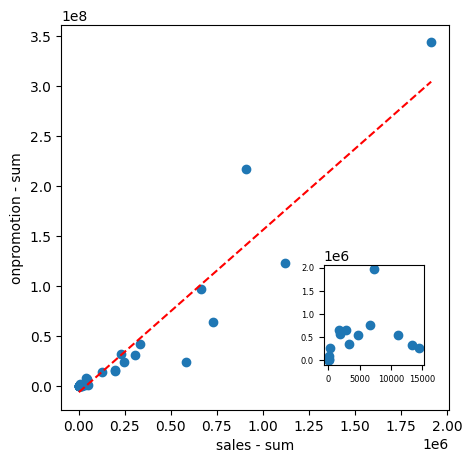

Spearman Correlation between Sales and Onpromotion by product family: 0.9475


In [8]:
# Is there a relationship between promotions and sales?
# Generally, there is a positive linear relationship between promotions and sales.
# However, product families with few promotions and sales deviate from this relationship.
dfPlotPromoSales = (df_train.groupby(['family'])[['sales', 'onpromotion']]
                    .sum()
                    .sort_values(by='onpromotion'))

x = dfPlotPromoSales['onpromotion']
y = dfPlotPromoSales['sales']

fig = plt.figure(figsize=(5,5))
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.xlabel('sales - sum')
plt.ylabel('onpromotion - sum')

subax = fig.add_axes([0.65, 0.2, 0.2, 0.2])
x_labelsize = subax.get_xticklabels()[0].get_size()
y_labelsize = subax.get_yticklabels()[0].get_size()
subax.xaxis.set_tick_params(labelsize=6)
subax.yaxis.set_tick_params(labelsize=6)
subax.scatter(x[:15], y[:15])

plt.show()

print("Spearman Correlation between Sales and Onpromotion by product family: {:,.4f}".format(dfPlotPromoSales.corr("spearman").sales.loc["onpromotion"]))

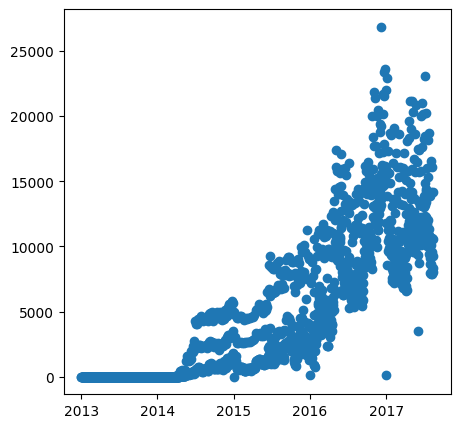

In [9]:
# Are there certain dates popular for promotions?
# Promotions have increased in popularity over time, especially since mid 2015.
dfPlotPromoDates = df_train.groupby(['date'])['onpromotion'].sum().sort_values(ascending=False).reset_index()

fig = plt.figure(figsize=(5,5))
plt.scatter(dfPlotPromoDates['date'], dfPlotPromoDates['onpromotion'])

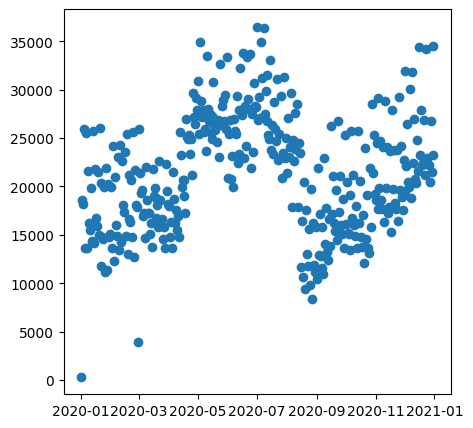

In [10]:
# What if I disregard year?
# Looks like promotions spike in the middle and at the end of the year.
# But this might not be true every year since there are many more promotions
# in the later years of the training set.
df_train2 = df_train.copy()

df_train2['month-day'] = df_train2['date'].apply(lambda x: x.replace(year = 2020))

dfPlotPromoMonthDay = df_train2.groupby(['month-day'])['onpromotion'].sum().sort_values(ascending=False).reset_index()

fig = plt.figure(figsize=(5,5))
plt.scatter(dfPlotPromoMonthDay['month-day'], dfPlotPromoMonthDay['onpromotion'])

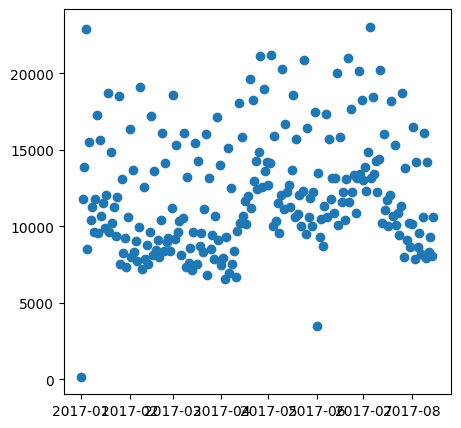

In [11]:
# Look at promotions on a yearly basis
# 2013 - no promotions
# 2014-2018 - looks like intraweek variability
# Not too much trend in time of year.
dfPlotPromoYear = dfPlotPromoDates[(dfPlotPromoDates['date'] >= '2017-01-01')
                                   & (dfPlotPromoDates['date'] < '2018-01-01')]
fig = plt.figure(figsize=(5,5))
plt.scatter(dfPlotPromoYear['date'], dfPlotPromoYear['onpromotion'])
plt.show()

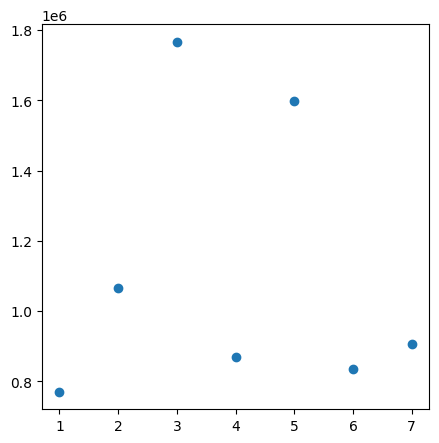

In [12]:
# Look at promotions by day of week
# Wednesdays and Fridays have nearly double the promotions of other days
df_train2['day'] = df_train2['date'].apply(lambda x: x.isoweekday())
dfPlotPromoDay = df_train2.groupby(['day'])['onpromotion'].sum().reset_index()

fig = plt.figure(figsize=(5,5))
plt.scatter(dfPlotPromoDay['day'], dfPlotPromoDay['onpromotion'])
plt.show()

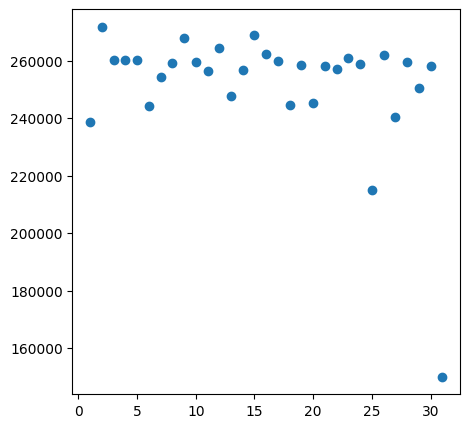

In [13]:
# How about promotions on public sector paydays (15th and last day of month)
# No trend here. Promotions drop on the 31st since some months don't have 31 days...
# ...I'm looking at the sum of promotions over all dates in the training set
df_train2['day-date'] = df_train2['date'].dt.day

dfPlotPromoDayDate = df_train2.groupby(['day-date'])['onpromotion'].sum().reset_index()

fig = plt.figure(figsize=(5,5))
plt.scatter(dfPlotPromoDayDate['day-date'], dfPlotPromoDayDate['onpromotion'])
plt.show()

In [14]:
# How about promotions on national holidays
# ~40% more promotions on national and all holidays than other days

# Just national holidays
df_train3 = pd.merge(df_train2, df_holi[df_holi['locale'] == 'National'][['date', 'type']], how='left', on='date')
# All holidays
# df_train3 = pd.merge(df_train2, df_holi[['date', 'type']], how='left', on='date')

df_train3['holiday'] = 1
df_train3.loc[df_train3['type'].isna(), 'holiday'] = 0

dfPlotPromoHoliday = df_train3.groupby(['holiday']).agg({'onpromotion': 'sum', 'date':'nunique'}).reset_index()

dfPlotPromoHoliday['norm'] = dfPlotPromoHoliday['onpromotion'] / dfPlotPromoHoliday['date']

dfPlotPromoHoliday.loc[1, 'norm'] / dfPlotPromoHoliday.loc[0, 'norm']

1.395863067752012

## df_trans

### Key takeaways
1. Eight of the 54 stores seem to have opened after the start date of the training set (2013-01-01).
2. The capital city (Quito) and state (Pinchincha) are home to 33% and 35% of total stores, respectively.
3. 75% (12 of 16) of states only have stores in one city.
4. 43% (7 of 16) of states only have one store.
5. Transactions spike at the end of the year.
6. Transactions decline from the start of the month to about the 10th, then rise.
7. Transactions spike on Saturdays and Sundays.

In [15]:
# First date with transactions by store
# Only 8 of 54 stores haven't logged transactions since the beginning of the training set
# Those 8 stores must have been opened after 2013-01-01
dfFirstTrans = df_trans.groupby('store_nbr')['date'].min().reset_index()

dfFirstTrans.groupby('date')['store_nbr'].count()

date
2013-01-01     1
2013-01-02    45
2013-05-09     1
2014-05-29     1
2015-02-13     1
2015-03-20     1
2015-07-24     1
2015-08-21     1
2015-10-09     1
2017-04-20     1
Name: store_nbr, dtype: int64

In [16]:
# Stores with most transactions
dfTransMax = df_trans.groupby('store_nbr')['transactions'].sum().sort_values(ascending=False).reset_index()

# Store with most transactions has 26x more than store with least transactions
dfTransMax.loc[0, 'transactions'] / dfTransMax.loc[53, 'transactions']

dfTransMax.describe()

,store_nbr,transactions
count,54.000000,5.400000e+01
mean,27.500000,2.619980e+06
std,15.732133,1.596024e+06
min,1.000000,2.753930e+05
25%,14.250000,1.533398e+06
50%,27.500000,2.248874e+06
75%,40.750000,3.181400e+06
max,54.000000,7.273093e+06


In [17]:
# Transactions by locale
dfTransGeo = pd.merge(dfTransMax, df_stores, how='left', on='store_nbr')

# Group by city
# Stores in Cayambe (1) and Quito (18) average the most transactions per store
dfTransCity = dfTransGeo.groupby(['city']).agg({'transactions': 'sum', 'store_nbr': 'count'}).reset_index()
dfTransCity['norm'] = dfTransCity['transactions'] / dfTransCity['store_nbr']
dfTransCity.sort_values(by='norm', ascending=False)

# Group by state
# Stores in the capital state (Pichincha) average ~25% more transactions than the second most state
dfTransState = dfTransGeo.groupby(['state']).agg({'transactions': 'sum', 'store_nbr': 'count'}).reset_index()
dfTransState['norm'] = dfTransState['transactions'] / dfTransState['store_nbr']
dfTransState.sort_values(by='norm', ascending=False)

# 1/3 of stores are in Quito
dfTransCity[dfTransCity['city'] == 'Quito']['store_nbr'] / dfTransCity.store_nbr.sum()

# 35% are in the state of the capital city, Quito (Pichincha)
dfTransState[dfTransState['state'] == 'Pichincha']['store_nbr'] / dfTransState.store_nbr.sum()

12    0.351852
Name: store_nbr, dtype: float64

In [18]:
# Group by type
# There are only 5 store types. Type A averages more than double the number of transactions
# per store than second place Type D
dfTransType = dfTransGeo.groupby(['type']).agg({'transactions': 'sum', 'store_nbr': 'count'}).reset_index()
dfTransType['norm'] = dfTransType['transactions'] / dfTransType['store_nbr']
dfTransType.sort_values(by='norm', ascending=False)

# Group by cluster
# There are 17 clusters with 1-7 stores each. The average number of transactions
# per store per cluster varies wildly (2.8 +/- 1.6).
dfTransClus = dfTransGeo.groupby(['cluster']).agg({'transactions': 'sum', 'store_nbr': 'count'}).reset_index()
dfTransClus['norm'] = dfTransClus['transactions'] / dfTransClus['store_nbr']
dfTransClus.sort_values(by='norm', ascending=False)

dfTransClus.describe()

# States and cities can have stores of different types
dfTransGeo.groupby(['state', 'city', 'type']).agg({'transactions': 'sum', 'store_nbr': 'count'}).reset_index()

,state,city,type,transactions,store_nbr
0,Azuay,Cuenca,B,2389482,1
1,Azuay,Cuenca,D,3284365,2
2,Bolivar,Guaranda,C,2107489,1
3,Chimborazo,Riobamba,C,2287850,1
4,Cotopaxi,Latacunga,C,3531356,2
5,El Oro,Machala,C,2181195,1
6,El Oro,Machala,D,1764146,1
7,Esmeraldas,Esmeraldas,E,2182356,1
8,Guayas,Daule,D,2485687,1
9,Guayas,Guayaquil,A,2873614,1


In [19]:
# 75% of states only have stores in one city
dfCityState = dfTransGeo.groupby(['state',]).agg({'store_nbr': 'nunique', 'city': 'nunique'}).reset_index()
dfCityState[dfCityState['city'] == 1]['state'].count() / dfCityState.state.count()

# ~43% of states only have one store
dfCityState[dfCityState['store_nbr'] == 1]['state'].count() / dfCityState.state.count()

0.4375

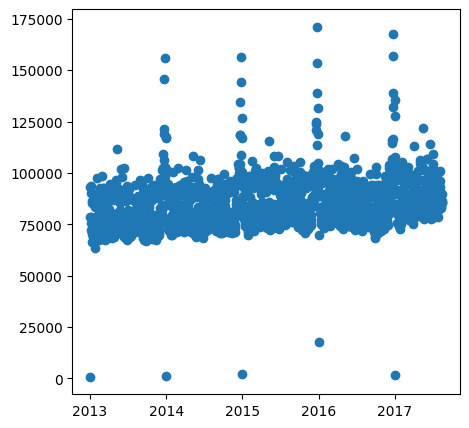

In [20]:
# Transactions over time
# Steady increase with spikes at end of year
df_transDate = df_trans.groupby('date').transactions.sum().reset_index()

fig = plt.figure(figsize=(5,5))
plt.scatter(df_transDate['date'], df_transDate['transactions'])
plt.show()

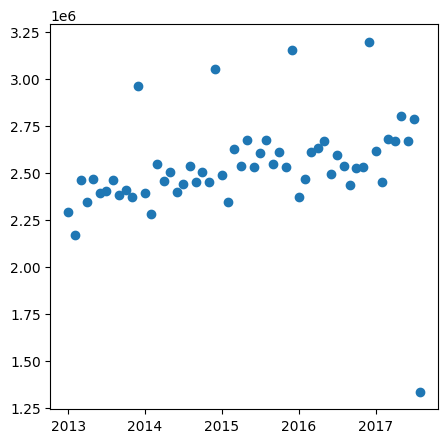

In [21]:
# Transactions by month
df_transDate['year-month'] = df_transDate['date'].apply(lambda x: x.replace(day = 1))

# Steady increase with spikes at end of year
df_transYearMonth = df_transDate.groupby('year-month').transactions.sum().reset_index()

fig = plt.figure(figsize=(5,5))
plt.scatter(df_transYearMonth['year-month'], df_transYearMonth['transactions'])
plt.show()

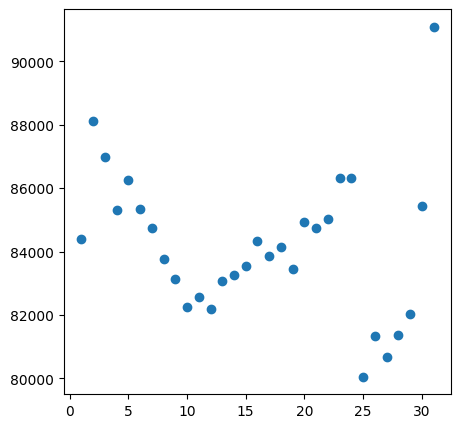

In [22]:
# Average transactions by day of month
# Transactions decline from the start of the month to about the 10th, then rise.
df_transDate = df_trans.groupby('date').transactions.sum().reset_index()
df_transDate['day'] = df_transDate.date.dt.day
df_transDay = df_transDate.groupby('day').transactions.mean().reset_index()

fig = plt.figure(figsize=(5,5))
plt.scatter(df_transDay['day'], df_transDay['transactions'])
plt.show()

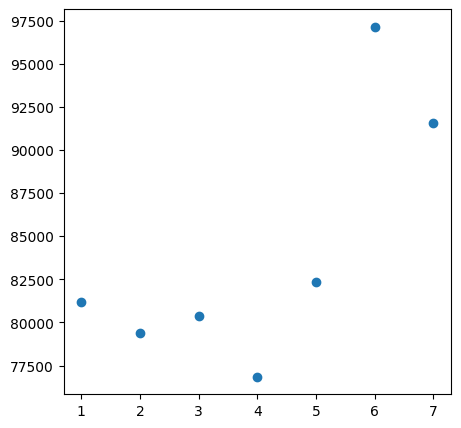

In [23]:
# Transactions by day of week
# Transactions spike on Saturdays and Sundays.
df_transDate['dayOfWeek'] = df_transDate.date.apply(lambda x: x.isoweekday())
df_transDayOfWeek = df_transDate.groupby('dayOfWeek').transactions.mean().reset_index()

fig = plt.figure(figsize=(5,5))
plt.scatter(df_transDayOfWeek['dayOfWeek'], df_transDayOfWeek['transactions'])
plt.show()

## df_oil

### Key takeaways
1. Oil prices moved from an average of 99 (dollars? per unit) to 47 (dollars? per unit) suddenly at the end of 2014.
2. Prices were relatively stable otherwise with the exception of 3 or 4 swings.
3. 43 dates are missing a daily oil price.
4. Weekends are not included in dataset.

Text(0.5, 1.0, 'Daily Oil Price')

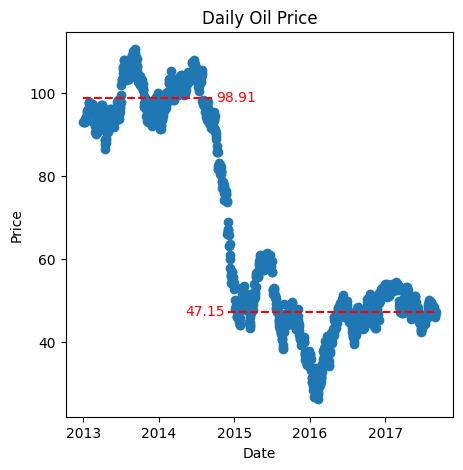

In [24]:
# Plot oil prices
x = df_oil['date']
y = df_oil['oil']

fig = plt.figure(figsize=(5,5))
plt.scatter(x, y)

# Average 'high' price
x1 = x[:450]
y1 = [y[:450].mean()]*450
plt.plot(x1, y1,"r--")
plt.text(16350, 98, round(y1[0], 2), color='red')

# Average 'low' price
x2 = x[500:]
y2 = [y[500:].mean()]*718
plt.plot(x2, y2,"r--")
plt.text(16200, 46.5, round(y2[0], 2), color='red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Daily Oil Price')

In [25]:
# Check for dates missing a daily price
# 43 dates missing a daily price
# Weekends are not included in dataset
df_oil[df_oil['oil'].isna()].date.count()

# Weekdays 5 and 6 (Saturday and Sunday) are missing from the dataset
df_oil.date.dt.weekday.reset_index().groupby(['date'])['date'].count()

date
0    243
1    244
2    244
3    244
4    243
Name: date, dtype: int64

## df_holi

### Key definitions
1.  A holiday on a row with column "transferred" equal to True was celebrated on a different date. <br>
    This date was treated like a regular day. The corresponding row with column "type" equal to Transfer <br>
    contains the date the holiday was celebrated.
2. "type" equal to Bridge is an additional day off added to the holiday.
3. "type" equal to Work Day is a day worked that is not normally worked (e.g., Saturday) <br>
    to make up for  a Bridge day.

### Key takeaways:
1. Most holidays are at the national or local level.
2. Holidays/events by year are not stable due to events. 2012 is light. <br>
    2014 has many events related to the World Cup. 2016 has many events related to the earthquake.
3. Most holidays are in the summer months or at the end of the year.
4. Holiday counts dip on Tuesdays and Wednesdays are are relatively stable on other days of the week.

In [26]:
# Breakdown of holidays by type
df_holi.groupby(['type'])['date'].count()

# Exclude multiple holidays on same date
df_holi.groupby(['type'])['date'].nunique()

type
Additional     51
Bridge          5
Event          55
Holiday       202
Transfer       12
Work Day        5
Name: date, dtype: int64

In [27]:
# Count of transferred holidays: 12
len(df_holi[df_holi['transferred'] == True])

# Were all holidays marked as "transferred" = True celebrated elsewhere?
# Yes
df_holi[df_holi['transferred'] == True]
df_holi[df_holi['type'] == 'Transfer']

len(df_holi[df_holi['transferred'] == True]) == len(df_holi[df_holi['type'] == 'Transfer'])

True

In [28]:
# Count of "type" equal to Bridge and Work Day both equal to 5.
# Are all five of each coordinated pairs? 
# Yes
df_holi[df_holi['type'] == 'Bridge']
df_holi[df_holi['type'] == 'Work Day']

,date,type,locale,locale_name,description,transferred
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


In [29]:
# Breakdown of holidays by locale
# Includes 12 duplicates due to transfers
df_holi.groupby(['locale'])['date'].count()

locale
Local       152
National    174
Regional     24
Name: date, dtype: int64

In [30]:
# Is the count of holidays/events per year relatively stable?
# No. Extra events in 2014 due to the World Cup and in 2016 due to the earthquake.
# 2012 is a light year.
df_holiYear = df_holi.copy()
df_holiYear['year'] = df_holiYear.date.dt.year
df_holiYear.groupby(['year']).date.count()

year
2012    41
2013    51
2014    67
2015    52
2016    86
2017    53
Name: date, dtype: int64

In [31]:
# Holidays/events by month
# Most holidays in summer months or at end of year
df_holiYear['month'] = df_holiYear.date.dt.month
df_holiYear.groupby(['month']).date.count()

month
1     10
2      8
3      9
4     44
5     44
6     31
7     36
8     26
9      7
10    15
11    49
12    71
Name: date, dtype: int64

In [32]:
# Holidays/events by day of week
# Count dips slightly on Tuesdays and Wednesdays
df_holiYear['day'] = df_holiYear['date'].apply(lambda x: x.isoweekday())
df_holiYear.groupby(['day']).date.count()

day
1    57
2    46
3    39
4    43
5    61
6    53
7    51
Name: date, dtype: int64

# 3. Prepare data

In [33]:
# Fill in missing dates in training set
# First training data date = 2013-01-01
train_start = df_train.date.min()

# Last training data date = 2017-08-15
train_end = df_train.date.max()

# Check for missing dates (discontinuities) in training data -> Christmas Day
missing_dates = pd.date_range(train_start, train_end).difference(df_train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()
print('Dates missing from training dataset: ', missing_dates)

# Stores are likely closed on Christmas. Add those dates to datset and fill in
# sales and onpromotion with 0s
# Reindex training data
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), df_train.store_nbr.unique(), df_train.family.unique()],
    names=["date", "store_nbr", "family"],
)
df_train = df_train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# Fill missing values with 0s
df_train[["sales", "onpromotion"]] = df_train[["sales", "onpromotion"]].fillna(0.)
df_train.id = df_train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

Dates missing from training dataset:  ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


In [34]:
# Check for continuity in transactions dataset
expected_trans = ((train_end - train_start).days + 1) * df_train.store_nbr.nunique()
total_trans = len(df_trans)
zero_trans = df_train.groupby(['date', 'store_nbr'])['sales'].sum().eq(0).sum()
miss_trans = expected_trans - total_trans - zero_trans

print('Expected entries: ', expected_trans)
print('Total entries:    ', total_trans)
print('Store-days with no entry: ', zero_trans)
print('Missing store-day entries: ', miss_trans)

Expected entries:  91152
Total entries:     83488
Store-days with no entry:  7546
Missing store-day entries:  118


In [35]:
# Coordinate dates, sales, and transactions
# Total sales per date for each store
dfStoreSalesDaily = df_train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# Reindex transaction data
df_trans = df_trans.merge(
    dfStoreSalesDaily,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# Fill missing values with 0s for days with zero sales
df_trans.loc[df_trans.sales.eq(0), "transactions"] = 0.
df_trans = df_trans.drop(columns=["sales"])

# Fill remaining missing values using linear interpolation
df_trans.transactions = df_trans.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [36]:
# Fill in missing dates (weekends) from oil data
# Reindex oil data
oil_start = df_oil.date.min()
oil_end = df_oil.date.max()

df_oil = df_oil.merge(
    pd.DataFrame({"date": pd.date_range(oil_start, oil_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# Fill missing values using the last price since the market is closed.
df_oil.oil = df_oil.oil.ffill()
# Then backfill since first date is 2013-01-01 and the market is closed.
df_oil.oil = df_oil.oil.bfill()

# Fill missing values using linear interpolation
# df_oil.oil = df_oil.oil.interpolate(method="linear", limit_direction="both")

In [37]:
# Streamline holiday/events data
# Remove all extraneous text from description
df_holi['description'] = df_holi.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""), axis=1,
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|guayaquil|santo domingo|cuenca|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).replace(
    r'.* futbol .*', "futbol", regex=True,
).replace(
    r'terremoto .*', "terremoto", regex=True,
).str.strip()

# Remove transferred holidays
df_holi = df_holi[df_holi['transferred'] == False]

# Extract work days
work_days = df_holi[df_holi.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)

hol_df = df_holi[df_holi['type'] != "Work Day"].reset_index(drop=True)

# Extract local holidays
local_holidays = df_holi[df_holi['locale'] == 'Local']
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)

local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

# Extract regional/state holidays
regional_holidays = df_holi[df_holi['locale'] == 'Regional']
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

# Extract national holidays
national_holidays = df_holi[df_holi['locale'] == 'National']
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# Different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# Shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

In [38]:
# Check for missing dates in test dataset
test_start = df_test.date.min()
test_end = df_test.date.max()

print('Dates missing from test dataset: ', pd.date_range(test_start, test_end).difference(df_test.date.unique()))

Dates missing from test dataset:  DatetimeIndex([], dtype='datetime64[ns]', freq='D')


# 4. Compile datasets

In [39]:
# Compile dfs
def compile_dfs(df):
    temp_df = df.merge(
        df_trans, on=["date", "store_nbr"], how="left",
    ).merge(
        df_oil, on="date", how="left",
    ).merge(
        df_stores, on="store_nbr", how="left",
    ).merge(
        work_days, on="date", how="left",
    ).merge(
        local_holidays, on=["date", 'city'], how="left",
    ).merge(
        regional_holidays, on=["date", 'state'], how="left",
    ).merge(
        national_holidays, on="date", how="left",
    ).sort_values(["date", "store_nbr", "family"], ignore_index=True)

    # Fill columns with 0s to indicate absence of holidays/events
    return temp_df.fillna(0)


df_trainNew = compile_dfs(df_train)
df_testNew = compile_dfs(df_test)

# 5. Additional analysis

In [40]:
# Are holidays significant to sales?
# Most are!
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == 1][target]
    groupB = dataframe[dataframe[group] == 0][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    temp["Feature"] = group
    temp["GroupA_mean"] = groupA.mean()
    temp["GroupB_mean"] = groupB.mean()
    temp["GroupA_median"] = groupA.median()
    temp["GroupB_median"] = groupB.median()
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    else:
        temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    
    # Print Hypothesis
    # print("# A/B Testing Hypothesis")
    # print("H0: A == B")
    # print("H1: A != B", "\n")
    
    return temp
    
# Apply A/B Testing
# he_cols = df_trainNew.columns[12:].tolist()
# ab = []
# for i in he_cols:
#     ab.append(AB_Test(dataframe=df_trainNew[df_trainNew.sales.notnull()], group = i, target = "sales"))
# ab = pd.concat(ab)
# ab

In [41]:
# QQ Plots - What are the data distributions?
# import statsmodels.graphics.gofplots as sm 

# for i in he_cols:
#     print(i)
#     df_trainNewPlotTmp = df_trainNew[df_trainNew['sales'].notnull()]
#     df_trainNewPlotTmp1 = df_trainNewPlotTmp[df_trainNewPlotTmp[i] == 1]['sales']
#     df_trainNewPlotTmp2 = df_trainNewPlotTmp[df_trainNewPlotTmp[i] == 0]['sales']
#     print("length of df1:", len(df_trainNewPlotTmp1))
#     print("length of df2:", len(df_trainNewPlotTmp2))

#     fig1, ax = plt.subplots(1, 2, figsize=(12, 7)) 
#     sns.histplot(df_trainNewPlotTmp1, kde=True, color ='blue',ax=ax[0]) 
#     sm.ProbPlot(df_trainNewPlotTmp1).qqplot(line='s', ax=ax[1])

#     fig2, ax = plt.subplots(1, 2, figsize=(12, 7)) 
#     sns.histplot(df_trainNewPlotTmp2, kde=True, color ='blue',ax=ax[0]) 
#     sm.ProbPlot(df_trainNewPlotTmp1).qqplot(line='s', ax=ax[1])

#     plt.show(block=False)
#     plt.pause(3)
#     plt.close()

# 6. Feature Engineering

In [42]:
# Add date details
def detailed_dates(df):
    df[['year', 'week', 'dayOfWeek']] = df['date'].dt.isocalendar().astype("category")
    df['day'] = df['date'].dt.day.astype('category')
    df['month'] = df['date'].dt.month.astype('category')
    df['day_of_year'] = df['date'].dt.dayofyear.astype('category')
    df['quarter'] = df['date'].dt.quarter.astype('category')
    df['is_month_end'] = df['date'].dt.is_month_end.astype('category')

    df["wageday"] = pd.Series(np.where((df['is_month_end'] == 1) | (df["day"] == 15), 1, 0)).astype('category')

    return df

df_trainNew = detailed_dates(df_trainNew)
df_testNew = detailed_dates(df_testNew)

In [43]:
# Combine datasets
store_sales = pd.concat([df_trainNew, df_testNew])

In [44]:
# Add lags based on simple moving average
a = store_sales.sort_values(["store_nbr", "family", "date"])
for i in [20, 30, 45, 60, 90, 120, 365, 730]:
    a["SMA"+str(i)+"_sales_lag16"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(16).values
    a["SMA"+str(i)+"_sales_lag30"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(30).values
    a["SMA"+str(i)+"_sales_lag60"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(60).values
print("Correlation")
a[["sales"]+a.columns[a.columns.str.startswith("SMA")].tolist()].corr()

Correlation


,sales,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60,SMA30_sales_lag16,SMA30_sales_lag30,SMA30_sales_lag60,SMA45_sales_lag16,SMA45_sales_lag30,SMA45_sales_lag60,...,SMA90_sales_lag60,SMA120_sales_lag16,SMA120_sales_lag30,SMA120_sales_lag60,SMA365_sales_lag16,SMA365_sales_lag30,SMA365_sales_lag60,SMA730_sales_lag16,SMA730_sales_lag30,SMA730_sales_lag60
sales,1.000000,0.915291,0.900332,0.880548,0.914642,0.902039,0.877354,0.915788,0.903713,0.876958,...,0.873477,0.911549,0.897871,0.871681,0.910022,0.899093,0.874316,0.912806,0.898187,0.867743
SMA20_sales_lag16,0.915291,1.000000,0.986425,0.958842,0.997440,0.983884,0.961829,0.993069,0.981706,0.962615,...,0.958463,0.981194,0.973912,0.955582,0.970279,0.967674,0.957933,0.970991,0.969629,0.957284
SMA20_sales_lag30,0.900332,0.986425,1.000000,0.969717,0.994520,0.997440,0.970740,0.996216,0.993069,0.972670,...,0.969268,0.985562,0.981194,0.966417,0.972013,0.970279,0.966191,0.971390,0.970991,0.967841
SMA20_sales_lag60,0.880548,0.958842,0.969717,1.000000,0.968819,0.977102,0.997440,0.977352,0.989195,0.993069,...,0.985811,0.988731,0.988029,0.981194,0.974266,0.973314,0.970278,0.972314,0.972011,0.970991
SMA30_sales_lag16,0.914642,0.997440,0.994520,0.968819,1.000000,0.992196,0.971137,0.997476,0.989047,0.972557,...,0.968963,0.985948,0.979645,0.966188,0.974180,0.971764,0.968255,0.973314,0.972154,0.968791
SMA30_sales_lag30,0.902039,0.983884,0.997440,0.977102,0.992196,1.000000,0.977300,0.997755,0.997476,0.977996,...,0.974733,0.989606,0.985948,0.971659,0.975755,0.974180,0.969525,0.973835,0.973314,0.970198
SMA30_sales_lag60,0.877354,0.961829,0.970740,0.997440,0.971137,0.977300,1.000000,0.978481,0.988128,0.997476,...,0.990293,0.991944,0.991509,0.985948,0.977980,0.977001,0.974180,0.974654,0.974373,0.973314
SMA45_sales_lag16,0.915788,0.993069,0.996216,0.977352,0.997476,0.997755,0.978481,1.000000,0.995918,0.978962,...,0.975463,0.990988,0.985964,0.972471,0.978457,0.976384,0.972060,0.975673,0.974668,0.971173
SMA45_sales_lag30,0.903713,0.981706,0.993069,0.989195,0.989047,0.997476,0.988128,0.995918,1.000000,0.986949,...,0.982353,0.993776,0.990988,0.978771,0.979880,0.978457,0.973898,0.976201,0.975673,0.972834
SMA45_sales_lag60,0.876958,0.962615,0.972670,0.993069,0.972557,0.977996,0.997476,0.978962,0.986949,1.000000,...,0.994676,0.995023,0.995059,0.990988,0.981945,0.981125,0.978457,0.976804,0.976656,0.975673


In [45]:
# Add lags based on exponential weighted moving average
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [16, 30, 60, 90]

a = ewm_features(a, alphas, lags)

# 7. Modeling

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

In [47]:
train = a[(a['date'] >= '2017-01-01') & (a['date'] < '2017-08-16')]
pred = a[a['date'] >= '2017-08-16']

In [48]:
train.dtypes[80:90]

sales_ewm_alpha_05_lag_16    float64
sales_ewm_alpha_05_lag_30    float64
sales_ewm_alpha_05_lag_60    float64
sales_ewm_alpha_05_lag_90    float64
dtype: object

In [49]:
# Prep data for modeling by store and family
store_sales = train.set_index(['store_nbr', 'family', 'date']).sort_index()

feature_set = ['sales', 'onpromotion', 'transactions', 'oil', 'work_day',
               'wageday', 'day_of_year', 'SMA20_sales_lag16', 'SMA30_sales_lag16',
               'sales_ewm_alpha_095_lag_16']

store_sales = (
    train
    .groupby(['store_nbr', 'family', 'date'])[feature_set]
    .mean()
    .unstack(['store_nbr', 'family'])
).dropna()

family_sales = (
    train
    .groupby(['family', 'date'])[feature_set]
    .mean()
    .unstack(['family'])
)

In [50]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method


In [51]:
def fit(self, X_1, X_2, y):
    # Fit self.model_1
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        # Make predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

In [52]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # Predict with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add method to class
BoostedHybrid.predict = predict

In [53]:
# Target series
y = store_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = store_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
# X_2["day"] = X_2.index.date  # values are day of the month

C:\Users\Collin Davies\AppData\Local\Temp\ipykernel_19544\3601071024.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_2 = store_sales.drop('sales', axis=1).stack()  # onpromotion feature


In [54]:
# Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

# Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

C:\Users\Collin Davies\AppData\Local\Temp\ipykernel_19544\2956894701.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_resid = y_resid.stack().squeeze() # wide to long
C:\Users\Collin Davies\AppData\Local\Temp\ipykernel_19544\752866559.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_pred = y_pred.stack().squeeze()  # wide to long


In [ ]:
# Update values to 0 for stores that don't sell products, or haven't recently
df_zeros = a.groupby(['store_nbr', 'family'])['sales'].sum().reset_index()

stores_zeros = df_zeros[df_zeros['sales'] == 0]['store_nbr'].to_list()
families_zeros = df_zeros[df_zeros['sales'] == 0]['family'].to_list()

for i, j in zip(stores_zeros, families_zeros):
    y_valid['value'] = np.where((y_valid['store_nbr'] == i) & (y_valid['family'] == j),
                                0,
                                y_valid['value'])

In [62]:
# Calculate RMSE for y_pred (validation set)
from sklearn.metrics import mean_squared_log_error

y_valid = pd.melt(y_pred, ignore_index=False).reset_index()
y_true = pd.melt(y, ignore_index=False).reset_index()

score = mean_squared_log_error(y_true=(y_true['value']), y_pred=(y_valid['value']), squared=True)
print(f'Validation RMSLE:{score :.5f}')

Validation RMSLE:0.20332


C:\Users\Collin Davies\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:675: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


In [63]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

In [66]:
y_fit

store_nbr          1                                                           \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-01-01   1.528951  0.000000  1.348441  1796.242535  0.147288   133.275499   
2017-01-02   2.466567  0.000000  2.280038  1795.349330  0.144313   298.184425   
2017-01-03   5.465074  0.364821  3.801965  2193.344523  1.141338   509.272363   
2017-01-04   3.393805  0.564597  3.665014  2414.662414  1.338362   484.545875   
2017-01-05   3.462089  0.164374  3.257501  2643.725659  0.935387   466.720804   
...               ...       ...       ...          ...       ...          ...   
2017-06-27   4.270639  0.000000  3.024677  2482.562921  0.020657   375.274437   
2017-06-28   3.869931  0.125512  2.790004  2250.267221  0.417682   392.167537   
2017-06-29   5.269223  0.125289  2.388232  2337.299676  0.414706   363.163837   
2017-06-30   6.668516  0.000000  2.786460  2442.068053  0.000000   425.125975   
2017-07-01   6.867808  0.000000  5.127834  2287.057789  0.208756   379.552450   

store_nbr                                                   ...        54  \
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-01-01    1.057037  187.646151  274.494078    0.000000  ...  0.000000   
2017-01-02    3.670177  472.962550  491.831953   71.543285  ...  0.778015   
2017-01-03   14.626235  730.768395  884.674314  196.142469  ...  2.989923   
2017-01-04   16.643333  914.903918  986.179252  176.943953  ...  0.590757   
2017-01-05   16.082595  827.064011  970.726750  149.040613  ...  2.191591   
...                ...         ...         ...         ...  ...       ...   
2017-06-27   17.618791  741.436985  741.547099  139.201939  ...  0.000000   
2017-06-28   19.292741  786.839907  799.799734  146.132300  ...  0.000000   
2017-06-29   15.507716  771.206906  710.947099  125.830534  ...  0.337550   
2017-06-30   16.522691  805.143360  818.115545  186.042026  ...  0.738384   
2017-07-01   13.937666  668.924169  819.915545  174.704358  ...  2.139218   

store_nbr                                                                  \
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000     61.701430     0.000000                3.678578   
2017-01-02  100.483790    300.144184     1.814292                7.444015   
2017-01-03   55.829056    258.373308     2.280378                5.712365   
2017-01-04   60.246752    211.255127     0.246198                5.969604   
2017-01-05   59.887270    216.553873     1.842430                5.740712   
...                ...           ...          ...                     ...   
2017-06-27   60.629421    144.402088     0.000000                2.120638   
2017-06-28   44.454978    130.884657     0.000000                1.509710   
2017-06-29   57.038531    142.484636     0.000000                1.698782   
2017-06-30   52.656419    147.446243     0.012082                2.487853   
2017-07-01   66.455198    282.296146     0.981480                3.508775   

store_nbr                                                                    \
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2017-01-01   0.000000      37.194295  453.723560                   0.979826   
2017-01-02  69.983232      87.814582  657.849887                   0.996418   
2017-01-03  59.887986      56.287169  860.669942                   1.413009   
2017-01-04  57.442313      72.722105  618.699964                   1.029600   
2017-01-05  59.460806      59.500120  475.398341                   1.246191   
...               ...            ...         ...                        ...

C:\Users\Collin Davies\AppData\Local\Temp\ipykernel_19544\2956894701.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_resid = y_resid.stack().squeeze() # wide to long
C:\Users\Collin Davies\AppData\Local\Temp\ipykernel_19544\752866559.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_pred = y_pred.stack().squeeze()  # wide to long
C:\Users\Collin Davies\AppData\Local\Temp\ipykernel_19544\752866559.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 

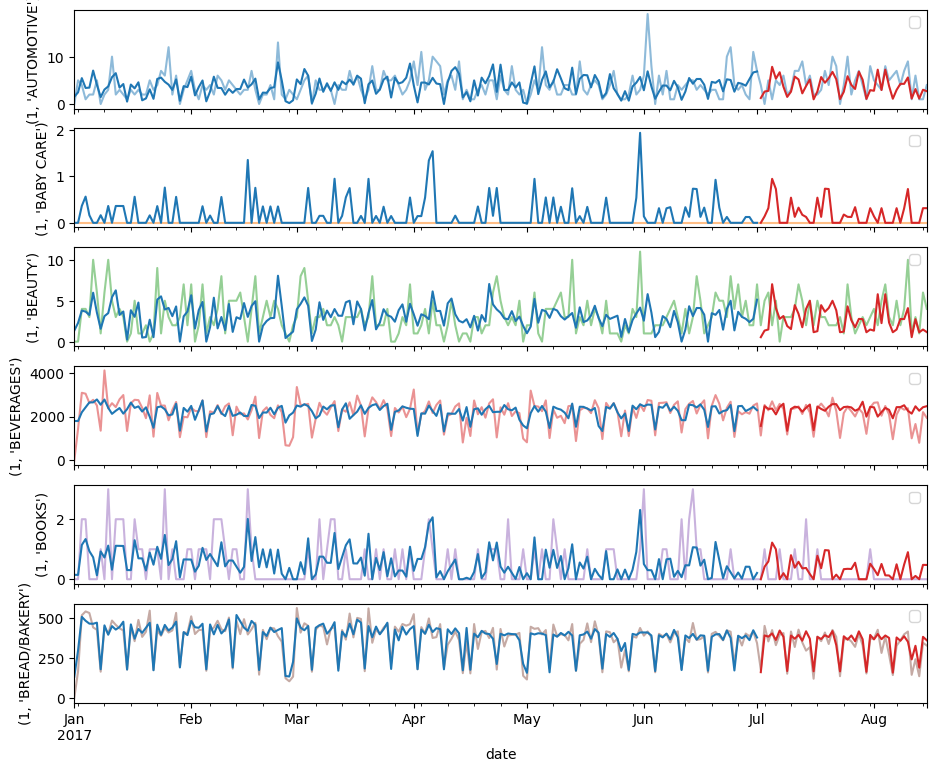

In [67]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

In [68]:
# Prediction
store_sales_pred = (
    pred
    .groupby(['store_nbr', 'family', 'date'])[feature_set]
    .mean()
    .unstack(['store_nbr', 'family'])
)

# X_1: Features for Linear Regression
dp = DeterministicProcess(index=store_sales_pred.index, order=1)
X_1_pred = dp.in_sample() + 1688

# X_2: Features for XGBoost
X_2_pred = store_sales_pred.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2_pred = X_2_pred.reset_index('family')
X_2_pred['family'] = le.fit_transform(X_2_pred['family'])


C:\Users\Collin Davies\AppData\Local\Temp\ipykernel_19544\1180245310.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_2_pred = store_sales_pred.drop('sales', axis=1).stack()  # onpromotion feature


In [69]:
y_pred = model.predict(X_1_pred, X_2_pred).clip(0.0)

C:\Users\Collin Davies\AppData\Local\Temp\ipykernel_19544\752866559.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_pred = y_pred.stack().squeeze()  # wide to long


# 8. Submission

In [70]:
y_pred_sub = pd.melt(y_pred, ignore_index=False)
pred_final = pd.merge(pred, y_pred_sub, how='left', on=['date', 'store_nbr', 'family'])

# Output to submit
output = pd.DataFrame({'id': pred_final.id, 'sales': pred_final.value})
output = output.sort_values(by='id')
output['id'] = output['id'].astype('int64')
output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
